<a href="https://colab.research.google.com/github/ShanmugapriyanManoharan/OpenCV-Deep-Learning/blob/master/Anamoly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from google.colab.patches import cv2_imshow
import random
import pickle

# *Convolutional Autoencoder*

In [0]:
class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		inputShape = (height, width, depth)
		chanDim = -1
		inputs = Input(shape=inputShape)
		x = inputs
		
		# Loop through the filter tuple
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
			
		# Flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)
		
		# Encoder Model
		encoder = Model(inputs, latent, name="encoder")
		
		# Latent-Space Representation
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
		
		# Loop through the filter tuple
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
			
		# Apply a single CONV_TRANSPOSE layer used to recover the original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)
		
		# Decoder model
		decoder = Model(latentInputs, outputs, name="decoder")
		
		# Autoencoder = encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
		
		return (encoder, decoder, autoencoder)

# **Build Unsupervised Dataset Function**

In [0]:
def build_unsupervised_dataset(data, labels, validLabel=1, anomalyLabel=3, contam=0.01, seed=42):
	validIdxs = np.where(labels == validLabel)[0] # Index of true labels
	anomalyIdxs = np.where(labels == anomalyLabel)[0] # Index of anamoly labels
	
	random.shuffle(validIdxs)
	random.shuffle(anomalyIdxs)
	
	# Get the total number of anamoly data points
	i = int(len(validIdxs) * contam)
	anomalyIdxs = anomalyIdxs[:i]
	
	validImages = data[validIdxs]
	anomalyImages = data[anomalyIdxs]
	
	# Stacking the images vertically
	images = np.vstack([validImages, anomalyImages])
	np.random.seed(seed)
	np.random.shuffle(images)
	
	return images

# **Visualization**

In [0]:
def visualize_predictions(decoded, gt, samples=10):
	outputs = None
	
	# Loop over the output samples
	for i in range(0, samples):
		original = (gt[i] * 255).astype("uint8")
		reconstructed = (decoded[i] * 255).astype("uint8")
		
		# Stack the images horizontally
		output = np.hstack([original, reconstructed])
		
		if outputs is None:
			outputs = output
		else:
			outputs = np.vstack([outputs, output]) # Vertical stacking3
			
	return outputs

# **Training**

In [0]:
EPOCHS = 25
LR = 1e-3 # Learning Rate
BS = 32 # Batch Size

In [0]:
# Load the MNIST Dataset
((trainX, trainY), (testX, testY)) = mnist.load_data()

# Building Unsupervised Dataset
images = build_unsupervised_dataset(trainX, trainY, validLabel=1, anomalyLabel=3, contam=0.01)

# Adding the channel dimension to every image
images = np.expand_dims(images, axis=-1)

# Pixel Intensity limited to range [0,1]
images = images.astype("float32") / 255.0

(trainX, testX) = train_test_split(images, test_size=0.2, random_state=42)

In [0]:
# Convolutional Autoencoder
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=INIT_LR, decay=LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)

In [12]:
# Training
A = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS)

Epoch 1/25
171/171 [==============================] - 1s 6ms/step - loss: 0.0365 - val_loss: 0.0403
Epoch 2/25
171/171 [==============================] - 1s 5ms/step - loss: 0.0107 - val_loss: 0.0250
Epoch 3/25
171/171 [==============================] - 1s 5ms/step - loss: 0.0043 - val_loss: 0.0078
Epoch 4/25
171/171 [==============================] - 1s 5ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 5/25
171/171 [==============================] - 1s 5ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 6/25
171/171 [==============================] - 1s 5ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/25
171/171 [==============================] - 1s 5ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 8/25
171/171 [==============================] - 1s 5ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 9/25
171/171 [==============================] - 1s 5ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 10/25
171/171 [==============================] - 1s 5ms/step - loss: 0.0022 - val_loss: 0.0023

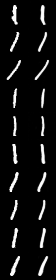

In [16]:
# Prediction
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)
cv2_imshow(vis)

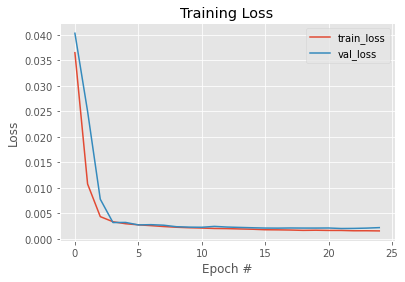

In [19]:
# Plotting Loss & Accuracy, saving the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, A.history["loss"], label="train_loss")
plt.plot(N, A.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

# **Dumping the Images using pickle**

In [0]:
# Writing the pickle image
f = open('anamoly_detection_image.pkl', "wb")
f.write(pickle.dumps(images))
f.close()

# **Saving the Model**

In [0]:
# Saving the Autoencoder model
autoencoder.save("convolutional_autoencoder.model", save_format="h5")

# **Finding Anamoly**

In [0]:
from tensorflow.keras.models import load_model

In [0]:
# Load the model and images
autoencoder = load_model('convolutional_autoencoder.model')
images = pickle.loads(open('anamoly_detection_image.pkl', "rb").read())

In [0]:
# Make predictions
decoded = autoencoder.predict(images)
errors = []

In [0]:
# Loop over the images
for (image, reconstructed) in zip(images, decoded):
  # Determine the MSE and append with the errors list
  mse = np.mean((image - reconstructed) ** 2)
  errors.append(mse)

In [0]:
thresh = np.quantile(errors, 0.999)
idxs = np.where(np.array(errors) >= thresh)[0] # Considered as outliers

In [35]:
print("MSE threshold: {}".format(thresh))
print("{} outliers found".format(len(idxs)))

MSE threshold: 0.026991694167256365
7 outliers found


In [0]:
outputs = None

# Looping over the images with high MSE
for i in idxs:
  original = (images[i] * 255).astype("uint8")
  reconstructed = (decoded[i] * 255).astype("uint8")

  output = np.hstack([original, reconstructed]) # Horizontal stacking of images

  if outputs is None:
    outputs = output
  else:
    outputs = np.vstack([outputs, output])

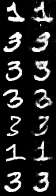

In [38]:
cv2_imshow(outputs)

***From the above images, we can find the anamoly/outlier '3' and even can find some '1' are incorrectly labelled as '3'. So some '1' also shown as outliers.***